In [1]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist
from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
path_corpus = Path('../../data/corpora/tutby_126784.csv')

path_emb = Path('../../data/emb/emb_tutby_126784_bert.npy')  # 0.283 0.342 | 0.070
# path_emb = Path('../../data/emb/emb_tutby_126784_bert_ppa2.npy')  # 0.866 1.0 | 0.089
# path_emb = Path('../../data/emb/emb_tutby_126784_bert_ppa4.npy')  # 0.886 1.0 | 0.089
# path_emb = Path('../../data/emb/emb_clean_tutby_126784_d2v.npy')  # 0.739 0.821 | 0.077
# path_emb = Path('../../data/emb/emb_clean_tutby_126784_d2v_ppa2.npy')  # 0.906 1.0 | 0.086
# path_emb = Path('../../data/emb/emb_clean_tutby_126784_w2v_idf.npy')  # 0.285 0.420 | 0.086
# path_emb = Path('../../data/emb/emb_tutby_126784_header_bert.npy')  # 0.555 0.635 | 0.059

In [3]:
data = pd.read_csv(path_corpus)

data['tags'] = data['tags'].apply(eval)
data['tags'] = data['tags'].apply(lambda tags: [tag.lower().strip() for tag in tags])

print(data.shape)
display(data.head(5))

(126784, 6)


,url,label,header,date,document,tags
0,https://news.tut.by/550306.html,Футбол,"Тренер ""Шахтера"": Оправдываться не хочу. Все в...",2017-07-06T21:35:00+03:00,Главный тренер солигорского «Шахтера» Олег Куб...,[футбол]
1,https://news.tut.by/550307.html,Общество,"""Зацветет"" ли каменная роза на ул. Комсомольск...",2017-07-07T09:25:00+03:00,Планы по восстановлению рисунка есть. Но пока ...,"[архитектура, живопись, жкх]"
2,https://news.tut.by/550308.html,Общество,Фотофакт. Скамейка в виде пожарной машины появ...,2017-07-07T09:27:00+03:00,Областное управление МЧС ко Дню пожарной служб...,[министерства]
3,https://news.tut.by/550309.html,Футбол,Станислав Драгун дебютировал за БАТЭ в матче с...,2017-07-06T22:11:00+03:00,Чемпион Беларуси БАТЭ воспользовался паузой в ...,"[футбол, батэ]"
4,https://news.tut.by/550310.html,В мире,Генпрокурор Украины пообещал открыть уголовное...,2017-07-06T22:28:00+03:00,Генпрокуратура Украины откроет уголовное произ...,"[ситуация в украине, государственные перевороты]"


In [4]:
with open(path_emb, 'rb') as file:
    embeddings = np.load(file)
    
index = np.isnan(embeddings).any(axis=1)
    
print(embeddings.shape)
print(index.sum())

data = data[~index]
embeddings = embeddings[~index]

print(data.shape)
print(embeddings.shape)

(126784, 768)
0
(126784, 6)
(126784, 768)


In [5]:
tags = data['tags'].explode().value_counts().index

dist_sum = 0.0
n_dists = 0

dists_sample_sim = []

for tag in tqdm(tags[::-1]):
    
    index = data['tags'].map(lambda _: tag in _)
    emb = embeddings[index]
    
    k = int(0.25 * len(emb)) + 1
    emb = np.random.permutation(emb)[:k]
    
    dists = cdist(emb, emb, metric='cosine')
    
    dist_sum += dists.sum()
    n_dists += dists.shape[0] ** 2 - dists.shape[0]
    dists_sample_sim += [dists]
    
dist_mean = dist_sum / n_dists
print(dist_mean)

dists_sample_sim = [_.flatten() for _ in dists_sample_sim]
dists_sample_sim = np.concatenate(dists_sample_sim)


0.2823437586784687


In [6]:
%%time

index0 = np.random.permutation(len(embeddings))[:10000]
index1 = np.random.permutation(len(embeddings))[:10000]

dists_sample = cdist(embeddings[index0], embeddings[index1], metric='cosine')

dists_sample = dists_sample.flatten()

dist_mean_ = dists_sample.mean()
print(dist_mean_)

0.3423896761031428
Wall time: 1min 32s


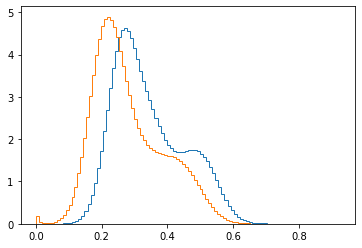

In [7]:
plt.hist(dists_sample, bins=100, density=True, histtype='step')
plt.hist(dists_sample_sim, bins=100, density=True, histtype='step')
plt.show()

In [8]:
%%time

ecdf = ECDF(dists_sample)
ecdf_sim = ECDF(dists_sample_sim)

# plt.plot(ecdf.x, ecdf.y)
# plt.plot(ecdf_sim.x, ecdf_sim.y)
# plt.show()

Wall time: 26.2 s


In [9]:
t = data['tags'].explode().value_counts().values
p_sim = (t ** 2).sum() / (t.sum() ** 2)

print(p_sim)

0.007677539546579642


In [10]:
%%time

a = np.quantile(dists_sample, 0.01)
b = np.quantile(dists_sample, 0.90)
print(a, b)

p_sim_left = p_sim * ecdf_sim(a) / ecdf(a)  # P(same|D<x)
p_sim_right = p_sim * (1.0 - ecdf_sim(b)) / (1.0 - ecdf(b))  # P(same|D>x)
score = p_sim_left - p_sim_right
print(score)

# d = np.linspace(a, b, num=1000)
# pp = p_sim * ecdf_sim(d) / ecdf(d)
# ppp = p_sim * (1.0 - ecdf_sim(d)) / (1.0 - ecdf(d))

# plt.plot(d, pp)
# plt.show()
# plt.plot(d, ppp)
# plt.show()

0.1628647976226752 0.5055618258067928
0.06970666364621989
Wall time: 4.53 s
